## SARIMA Forecasting of Weather Data

This project uses SARIMA modelling to forecast hourly weather data for Atlanta, GA, called through an open API. Statistical and visualization techniques are implemented to determine candidates for the best model, and AICc is used to determine the best model. The project implements a train/test step to evaluate the models performance on observed data, and then forecasts the temperature for future days.

In [1]:
# Required installations and imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import openmeteo_requests
import requests_cache
from retry_requests import retry

import API_process
import my_train_split

### Calling the API
Using the Open-Meteo API which stores data for given coordinates. In this case, Atlanta data is retrieved. 

Coordinates 33.77855682373047°E -84.40298461914062°N
Elevation 327.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s


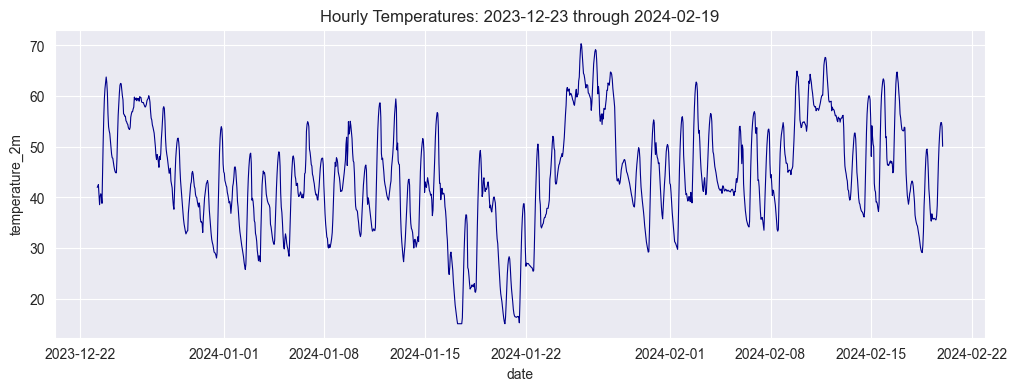

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# The API call will retrieve data from 60 days ago through 2 days ago - this ensures we
# always have full days worth of data.
prev_2_date = datetime.today() - timedelta(2)
prev_2_date = prev_2_date.strftime("%Y-%m-%d")

prev_60_date = datetime.today() - timedelta(60)
prev_60_date = prev_60_date.strftime("%Y-%m-%d")

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "longitude": -84.3877,
    "latitude": 33.7488,
    "start_date": prev_60_date,
    "end_date": prev_2_date,
    "hourly": "temperature_2m",
    "temperature_unit": "fahrenheit",
    "timezone": "America/New_York",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


# Process hourly data. The order of variables needs to be the same as requested.
hourly_dataframe, hourly_dataframe_original = API_process.API_process(response)

plt.figure(figsize=(12, 4))

sns.lineplot(
    data=hourly_dataframe, x="date", y="temperature_2m", color="darkblue", lw=0.8
)
plt.title(f"Hourly Temperatures: {prev_60_date} through {prev_2_date}")
plt.show()

## Box-Cox Transform

In [3]:
# Box-Cox transform only applied if the lambda value is outside of [0.8, 1.2]

test_box_frame, test_best_lambda = boxcox(hourly_dataframe["temperature_2m"])
print(f"The test lambda value: {test_best_lambda}")

if 0.8 <= test_best_lambda <= 1.2:
    pass
else:
    hourly_dataframe["temperature_2m"], best_lambda = boxcox(
        hourly_dataframe["temperature_2m"]
    )
    print(f"The required lambda value: {best_lambda}")

The test lambda value: 1.2037622296167074
The required lambda value: 1.2037622296167074


## Diagnostic Steps
We will be using SARIMA to forecast hourly trends. We will utilize statistical tests to determine our best parameter estimates for the model. Our data is clearly not stationary, there is trend and seasonality present within, and possibly cyclic behavior which would greatly influence the AR() piece of our ARIMA model. To provide more evidence of non-stationarity, as well as a method for testing stationarity after differencing, we use the ADF test and analyze ACF and PACF plots. 

ADF Statistic: -4.5102226158844605
p-value 0.00018844350430079437
Critical Values {'1%': -3.4350768776774996, '5%': -2.8636275726388236, '10%': -2.5678814189722416}


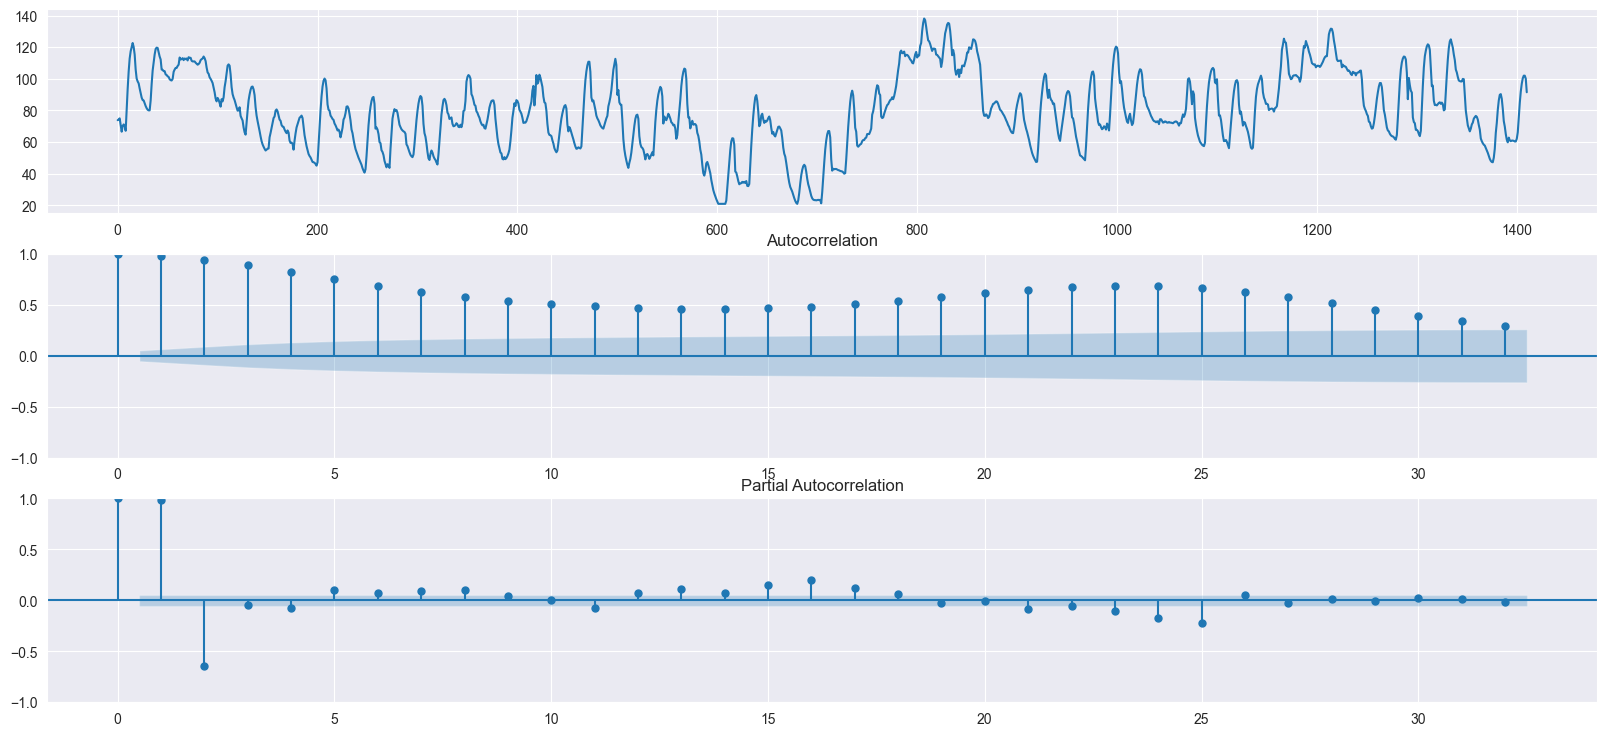

In [4]:
# Our p-value is not significant, and our ADF statistic is greater than our critical values, all pointing to non-stationarity.
# The diagnostic plots show significant non-stationarity, as the ACF plot is not dropping quickly and fails to fall below
# the significant level.

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 9))
ax1.plot(hourly_dataframe["temperature_2m"])
plot_acf(hourly_dataframe["temperature_2m"], ax=ax2)
plot_pacf(hourly_dataframe["temperature_2m"], method="ywm", ax=ax3)

result = adfuller(hourly_dataframe["temperature_2m"])
print("ADF Statistic:", result[0])
print("p-value", result[1])
print("Critical Values", result[4])

ADF Statistic: -5.048584804404516
p-value 1.776998921361451e-05
Critical Values {'1%': -3.4351603284454986, '5%': -2.863664398126376, '10%': -2.567901029668299}


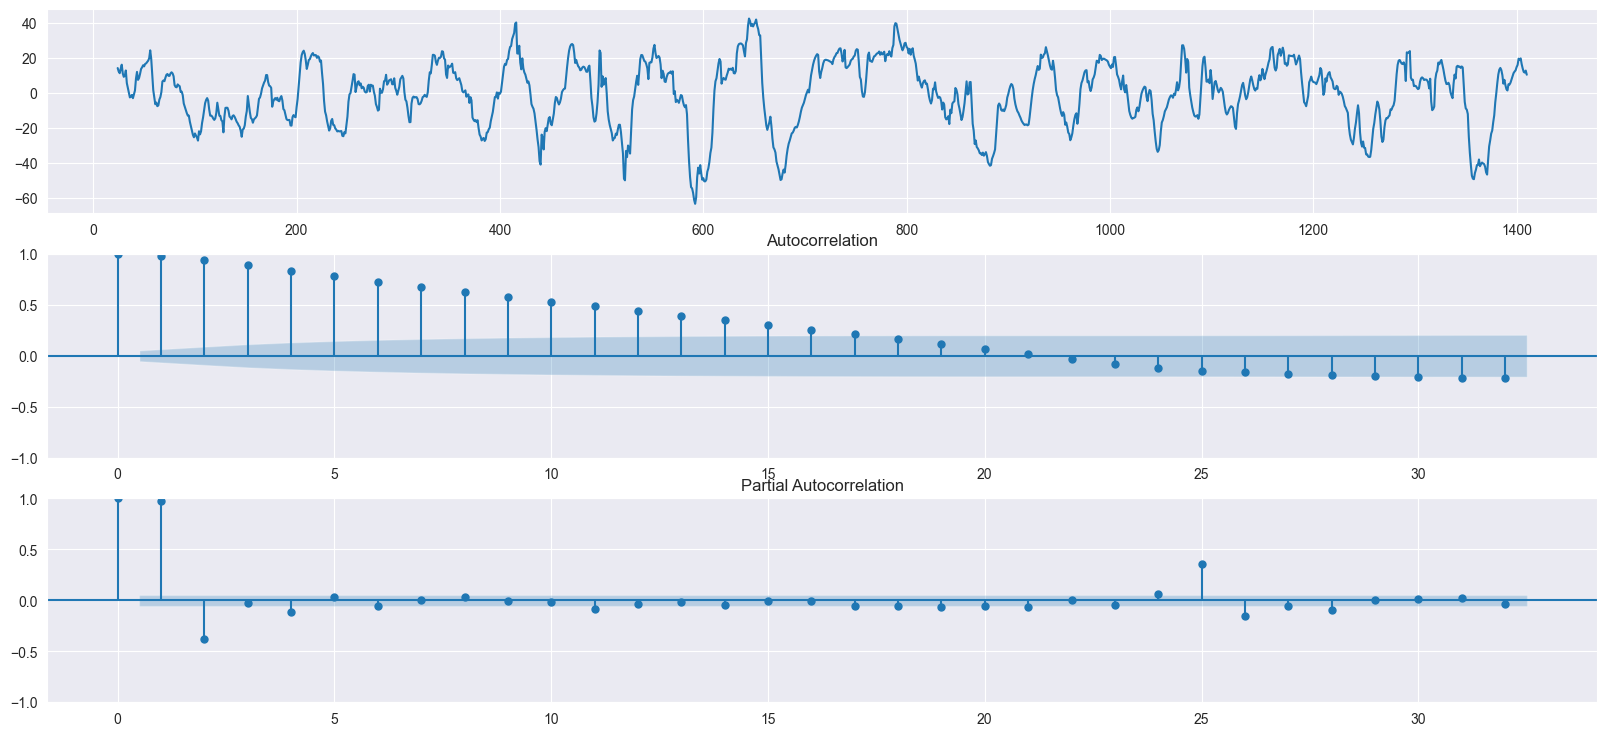

In [5]:
# Introducing differencing in our data - we first introduce a seasonal difference, and then regular differencing
# if needed. We first try the seasonal differencing in case that covers the stationary needs. As seen below
# the seasonal differencing covers the stationary requirement. The p-value is significant, our ADF statistic
# falls well below the critical values, and the plots resemble white noise more closely.

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 9))
diff_seas_data = hourly_dataframe["temperature_2m"].diff(24).dropna()
# diff_data = diff_seas_data.diff().dropna()
ax1.plot(diff_seas_data)
plot_acf(diff_seas_data.dropna(), ax=ax2)
plot_pacf(diff_seas_data.dropna(), method="ywm", ax=ax3)

result = adfuller(diff_seas_data)
print("ADF Statistic:", result[0])
print("p-value", result[1])
print("Critical Values", result[4])

## SARIMA model

We have stationary data with seasonal differencing. We aim to estimate $p$ and $q$ for the ARIMA(p,d,q) piece of the model. Looking at the seasonal lags, there is a very significant spike at 24 for the ACF and PACF, which could suggest a seasonal AR(1) or a seasonal MA(1). Looking at non-seasonal lags, the ACF has significant spikes to 3, which points to a non-seasonal MA(3), and the PACF similarly suggests a AR(2).

In [8]:
X_train, X_test, y_train, y_test = my_train_split.my_train_split(
    hourly_dataframe["date"], hourly_dataframe["temperature_2m"]
)

# Fitting various models based on our ACF/PACF plots, and then auto-fitting a model
# to compare results against and determine if a better model can be found.
model2110 = sarimax.SARIMAX(y_train, order=(2, 0, 0), seasonal_order=(1, 1, 0, 24))
res_model2110 = model2110.fit(disp=False)
model2011 = sarimax.SARIMAX(y_train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 24))
res_model2011 = model2011.fit(disp=False)
model3110 = sarimax.SARIMAX(y_train, order=(0, 0, 3), seasonal_order=(1, 1, 0, 24))
res_model3110 = model3110.fit(disp=False)
model3011 = sarimax.SARIMAX(y_train, order=(0, 0, 3), seasonal_order=(0, 1, 1, 24))
res_model3011 = model3011.fit(disp=False)
auto_model = pm.auto_arima(
    y_train,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=5,
    max_q=5,
    m=24,  # 24 is the frequncy of the cycle
    start_P=1,
    seasonal=True,  # set to seasonal
    d=None,
    D=1,  # order of the seasonal differencing
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

# Using AICc values to compare models. From the AICc values below,
# the best model seems to be the ARIMA(2,0,0)(0,1,1)[24]
# Each model below has the same differencing so the AICc values are comparable.
print("The aicc of model 2110:", res_model2110.aicc)
print("The aicc of model 2011:", res_model2011.aicc)
print("The aicc of model 3110:", res_model3110.aicc)
print("The aicc of model 3011:", res_model3011.aicc)
print("The aicc of auto model:", auto_model.aicc())
print("The auto model:", auto_model)

/Users/coleparker/Documents/Udemy/Personal Challenges/Weather_Prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/coleparker/Documents/Udemy/Personal Challenges/Weather_Prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The aicc of model 2110: 5774.545423287252
The aicc of model 2011: 5413.550564198565
The aicc of model 3110: 6849.75619623684
The aicc of model 3011: 6782.654852538835
The aicc of auto model: 5622.824899886264
The auto model:  ARIMA(4,0,0)(2,1,0)[24]          


## Residuals
Analyzing the residuals of the ARIMA(2,0,0)(0,1,1)[24] model above
- From the below diagnostics, we can see that the standardized residuals do not have a clear shape and are fairly evenly scattered across all values, so this is a good sign. 
- The KDE plot is normally distributed around a mean of 0.
- In the Normal Q-Q plot, the points are closely aligned with the center line, which indicates a normal distribution. 
- With the seasonality, most/all of our values fall within the 95% confidence interval. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       temperature_2m   No. Observations:                 1128
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -2702.757
Date:                              Wed, 21 Feb 2024   AIC                           5413.514
Time:                                      06:26:20   BIC                           5433.541
Sample:                                           0   HQIC                          5421.089
                                             - 1128                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3571      0.019     72.321      0.000       1.320       1.394
ar.L2         -0.3701      0.018    -20.170      0.000      -0.406      -0.334
ma.S.L24      -0.9484      0.016    -61.069      0.000      -0.979      -0.918
sigma2         7.4363      0.183     40.746      0.000       7.079       7.794
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1388.03
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

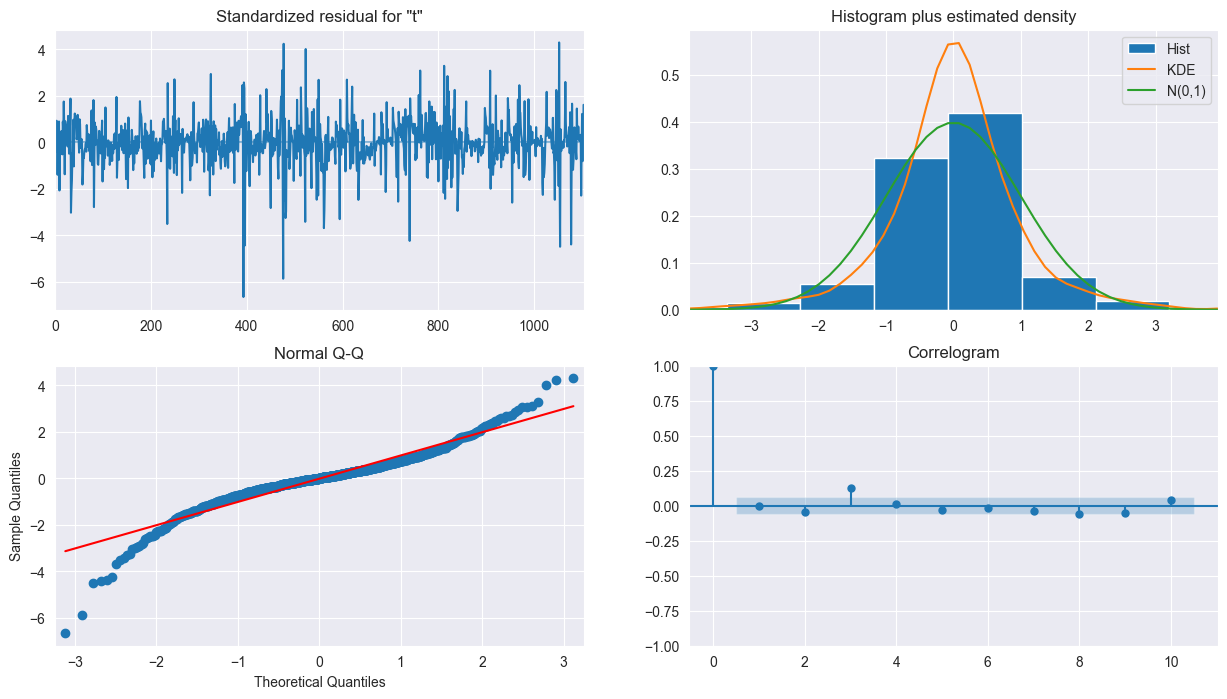

In [9]:
# Plots to analyze residuals - ensuring no correlation.
res_model2011.plot_diagnostics(figsize=(15, 8))

# Ljung-Box test - the result of the test has a p value > 0.05, so we
# can say the residuals are most likely resembling white noise, and there are
# not significant correlations in the residuals.
res_model2011.summary()

The RMSE value in Fahrenheit: 9.617238715035304


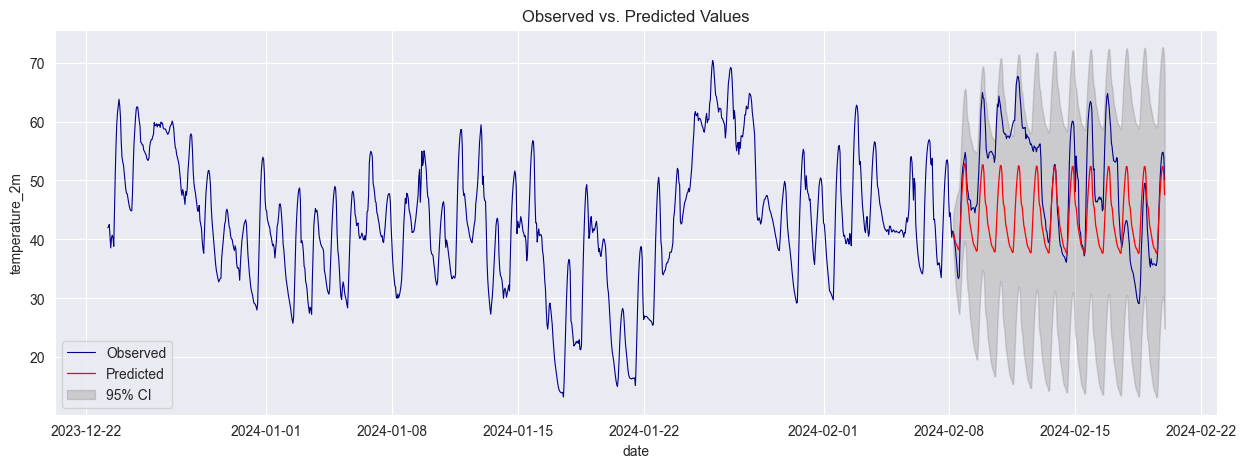

In [10]:
# Predictions on our test data for the ARIMA model.
test_predict = res_model2011.get_prediction(
    start=len(X_train), end=len(hourly_dataframe) - 1
)
yhat_predict = test_predict.predicted_mean
yhat_conf_predict = test_predict.conf_int(alpha=0.05)

# Inverse Box Cox if required
if 0.8 <= test_best_lambda <= 1.2:
    pass
else:
    y_test = inv_boxcox(y_test, best_lambda)
    yhat_predict = inv_boxcox(yhat_predict, best_lambda)
    yhat_conf_predict = inv_boxcox(yhat_conf_predict, best_lambda)

final_test = pd.DataFrame(
    data=pd.concat(
        [
            yhat_predict.reset_index().drop("index", axis=1),
            yhat_conf_predict.reset_index().drop("index", axis=1),
        ],
        axis=1,
    )
)
final_test = pd.concat(
    [final_test, X_test.sort_values().reset_index().drop("index", axis=1)], axis=1
)
final_test.columns = ["pred", "yhat_lower", "yhat_upper", "date"]
final_test

# Visualizing the observed and predicted values aids in understanding the
# RMSE results, and overall performance.
plt.figure(figsize=(15, 5))

plt.title("Observed vs. Predicted Values")
sns.lineplot(
    data=hourly_dataframe_original,
    x="date",
    y="temperature_2m",
    color="darkblue",
    lw=0.8,
    label="Observed",
)
sns.lineplot(
    data=final_test, x="date", y="pred", color="red", lw=0.9, label="Predicted"
)
plt.fill_between(
    final_test["date"],
    final_test["yhat_lower"],
    final_test["yhat_upper"],
    color="grey",
    alpha=0.3,
    label="95% CI",
)
plt.legend(loc="lower left")

# Calculating RMSE. We choose RMSE over MSE since it can be interpretted
# in the units of the target variable. MAPE is not best practice for
# temperature data due to the presence of values near/below zero.
RMSE = np.sqrt(np.square(y_test.values - final_test["pred"].values).sum() / len(y_test))
print("The RMSE value in Fahrenheit:", RMSE)

## Forecasting

Using the ARIMA(2,0,0)(0,1,1)[24] model to forecast future values. 
\
The dynamic window over which to forecast can be changed by adjusting the forecast_window_days variable below. Currently it is set to forecast seven days into the future. 

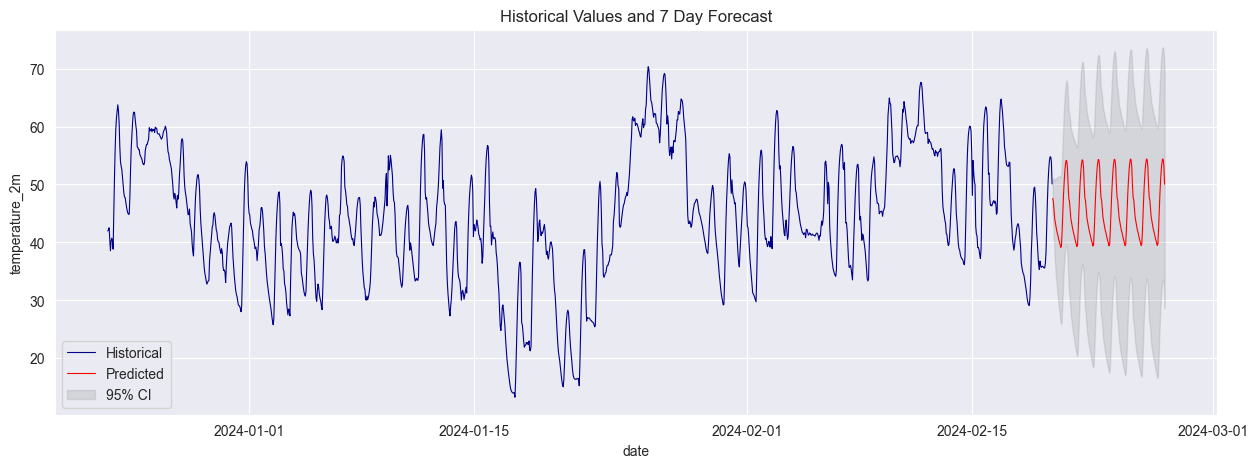

In [11]:
# Refitting our model on the entire dataset

model2011_future = sarimax.SARIMAX(
    hourly_dataframe["temperature_2m"], order=(2, 0, 0), seasonal_order=(0, 1, 1, 24)
)
res_model2011_future = model2011_future.fit(disp=False)

# Dynamic dataframes to forecast indicated number of days out from previous day.
# Change forecast_window_days to change
forecast_window_days = 7

# Based on forecast days, determine start and end dates
forecast_window = forecast_window_days * 24
start_date = datetime.strptime(prev_2_date, "%Y-%m-%d") + timedelta(1)
end_date = start_date + timedelta(forecast_window_days)

forecasted_hours = []

# Create list of hourly datetime stamps
delta = timedelta(hours=1)
while start_date < end_date:
    forecasted_hours.append(start_date)
    start_date += delta
forecasted_hours = pd.Series(forecasted_hours)

# Generate forecast over the given window
forecasted = res_model2011_future.get_forecast(forecast_window)
forecasted_mean = forecasted.predicted_mean
forecasted_intervals = forecasted.conf_int(alpha=0.05)

# Inverse Box Cox if needed
if 0.8 <= test_best_lambda <= 1.2:
    pass
else:
    forecasted_mean = inv_boxcox(forecasted_mean, best_lambda)
    forecasted_intervals = inv_boxcox(forecasted_intervals, best_lambda)

# Combine the datetime stamps and the generated forecast
forecast_agg = pd.concat(
    [forecasted_hours, forecasted_mean.reset_index().drop("index", axis=1)], axis=1
)
forecast_agg = pd.concat(
    [forecast_agg, forecasted_intervals.reset_index().drop("index", axis=1)], axis=1
)

# Visualizing the historical observed and forecasted data
plt.figure(figsize=(15, 5))

plt.title(f"Historical Values and {forecast_window_days} Day Forecast")
sns.lineplot(
    data=hourly_dataframe_original,
    x="date",
    y="temperature_2m",
    color="darkblue",
    lw=0.8,
    label="Historical",
)
sns.lineplot(
    data=forecast_agg, x=0, y="predicted_mean", color="red", lw=0.8, label="Predicted"
)
plt.fill_between(
    forecast_agg[0],
    forecast_agg["lower temperature_2m"],
    forecast_agg["upper temperature_2m"],
    color="grey",
    alpha=0.2,
    label="95% CI",
)
plt.legend(loc="lower left")
plt.show()